In [92]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seawater as sw
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features

fig_dir='C:/Users/gentemann/Google Drive/f_drive/docs/projects/misst-arctic/Saildrone/'


## read in ice present file

In [93]:
icefile='C:/Users/gentemann/Google Drive/f_drive/docs/projects/misst-arctic/Ice Present.xlsx'
ds = pd.read_excel(icefile, sheet_name='data',index_col=0)
ds_ice = ds.to_xarray()

## check data

In [94]:
ds_ice
ds_ice.sel(usv=1037)

<xarray.Dataset>
Dimensions:     (usv: 3)
Coordinates:
  * usv         (usv) int64 1037 1037 1037
Data variables:
    start_time  (usv) datetime64[ns] 2019-06-17T08:00:00 ... 2019-08-04
    stop_time   (usv) datetime64[ns] 2019-06-21T12:00:00 ... 2019-08-08T18:00:00

## Read in all the cruise full data

- swap dims from obs to time
- I checked & time = for both trajectories

In [96]:
adir = 'F:/data/cruise_data/saildrone/2019_arctic/post_mission/'
list_usv=[1033,1034,1035,1036,1037]
#file = adir + 'saildrone-gen_5-arctic_misst_2019-sd'+str(iusv)+'-20190514T230000-20191011T183000-1_minutes-v1.1575487464625.nc'
ds = xr.open_mfdataset(adir+'*.nc',combine='nested',concat_dim='trajectory').load()
ds['wspd_MEAN']=np.sqrt(ds.UWND_MEAN**2+ds.VWND_MEAN**2)
ds['wdir_MEAN']=np.arctan2(ds.VWND_MEAN,ds.UWND_MEAN)*180./np.pi
ds = ds.rename({'latitude':'lat','longitude':'lon'})
ds['time']=ds.time[0,:]
ds = ds.swap_dims({'obs':'time'})

In [ ]:
ds2=ds.copy(deep=True)
#get rid of bad salinity values
ds['SAL_RBR_MEAN'] = ds.where(ds.SAL_RBR_MEAN>20)
ds['SAL_SBE37_MEAN'] = ds.where(ds.SAL_SBE37_MEAN>20)
#remove ice regions where salinity variability high
for iusv in range(2):
    ice = ds_ice.isel(usv=iusv)
    sdif=ds.SAL_SBE37_MEAN-ds.SAL_RBR_MEAN
    sdif2 = sdif.copy(deep=True)
    ind=sdif*0
    for i in range(ice.usv.size):
        cond = (sdif.time>ice.start_time[i]) & (sdif.time<ice.stop_time[i])
        sdif2[cond]=np.nan

In [ ]:
#checking that time was identical for both trajectory
#for i in range(10):
#    print(ds.time[:,i].data)
    

## Plot all the Variables 

In [97]:
for var in ds.variables:
    if 'MEAN' in var:
        print(var)
        ax=ds[var][0,:].plot(linewidth=.5,color='r',label='1036')
        ax=ds[var][1,:].plot(linewidth=.5,color='b',label='1037')
        plt.legend()
        plt.title('')
        plt.savefig(fig_dir+'figs/'+var+'.png')
        plt.clf()

SOG_FILTERED_MEAN
COG_FILTERED_MEAN
HDG_FILTERED_MEAN
ROLL_FILTERED_MEAN
PITCH_FILTERED_MEAN
WING_HDG_FILTERED_MEAN
WING_ROLL_FILTERED_MEAN
WING_PITCH_FILTERED_MEAN
UWND_MEAN
VWND_MEAN
WWND_MEAN
GUST_WND_MEAN
WIND_HEIGHT_MEAN
TEMP_AIR_MEAN
RH_MEAN
BARO_PRES_MEAN
PAR_AIR_MEAN
TEMP_IR_SKY_HULL_MEAN
TEMP_IR_SEA_HULL_UNCOMP_MEAN
TEMP_IR_SEA_WING_UNCOMP_MEAN
TEMP_SBE37_MEAN
SAL_SBE37_MEAN
COND_SBE37_MEAN
TEMP_CTD_RBR_MEAN
SAL_RBR_MEAN
COND_RBR_MEAN
O2_CONC_SBE37_MEAN
O2_SAT_SBE37_MEAN
O2_CONC_RBR_MEAN
O2_SAT_RBR_MEAN
TEMP_O2_RBR_MEAN
CHLOR_WETLABS_MEAN
CHLOR_RBR_MEAN
wspd_MEAN
wdir_MEAN


<Figure size 432x288 with 0 Axes>

## Plot SSTs on map to show where vehicles whent

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


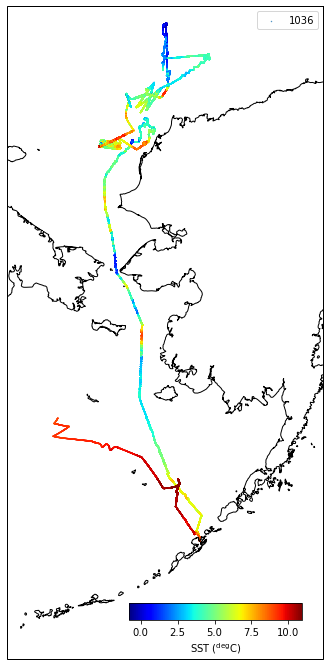

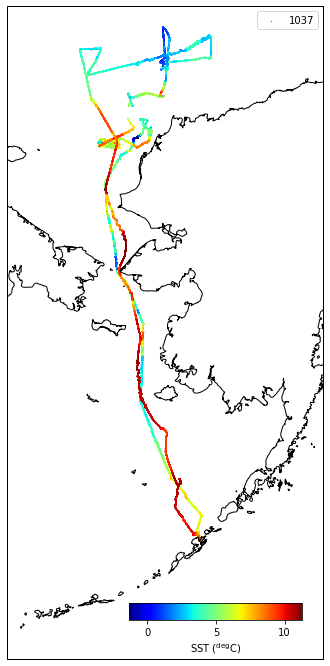

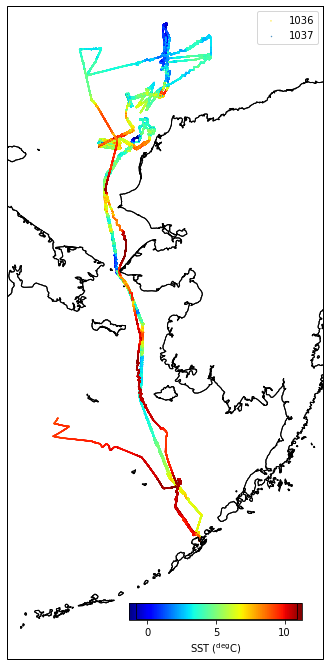

In [98]:
for i in range(2):
    fig = plt.figure(figsize=(8,12))
    ax = plt.axes(projection = ccrs.NorthPolarStereo(central_longitude=180.0))  # create a set of axes with Mercator projection
    ds2 = ds.isel(trajectory=i)
    im=ax.scatter(ds2.lon,ds2.lat,c=ds2.TEMP_SBE37_MEAN,s=.15,transform=ccrs.PlateCarree(),label=ds.trajectory[i].data,cmap='jet')
    ax.coastlines(resolution='10m')                
    ax.set_extent([-180,-160,50,77])
    ax.legend()
    cax = fig.add_axes([0.45, 0.17, 0.3, 0.02])
    cbar = fig.colorbar(im,cax=cax, orientation='horizontal')
    cbar.set_label('SST ($^\deg$C)')
    fig.savefig(fig_dir+'figs/map_nasa'+str(i).zfill(2)+'_data.png')    
fig = plt.figure(figsize=(8,12))
ax = plt.axes(projection = ccrs.NorthPolarStereo(central_longitude=180.0))  # create a set of axes with Mercator projection
for i in range(2):
    ds2 = ds.isel(trajectory=i)
    im=ax.scatter(ds2.lon,ds2.lat,c=ds2.TEMP_SBE37_MEAN,s=.15,transform=ccrs.PlateCarree(),label=ds.trajectory[i].data,cmap='jet')
    ax.coastlines(resolution='10m')                
    ax.set_extent([-180,-160,50,77])
    ax.legend()
    cax = fig.add_axes([0.45, 0.17, 0.3, 0.02])
    cbar = fig.colorbar(im,cax=cax, orientation='horizontal')
    cbar.set_label('SST ($^\deg$C)')
    fig.savefig(fig_dir+'figs/map_nasa_data.png')

## make plot air sea tem difference

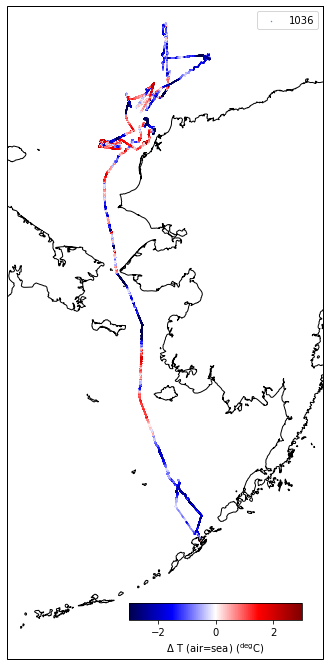

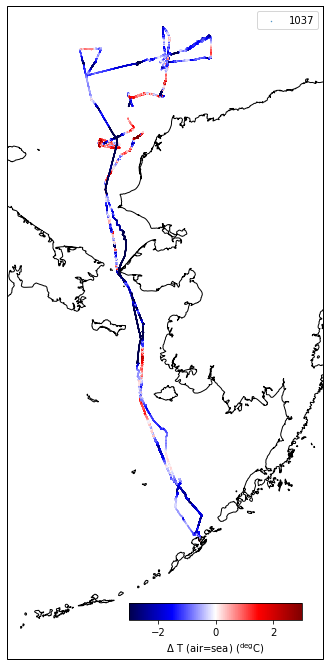

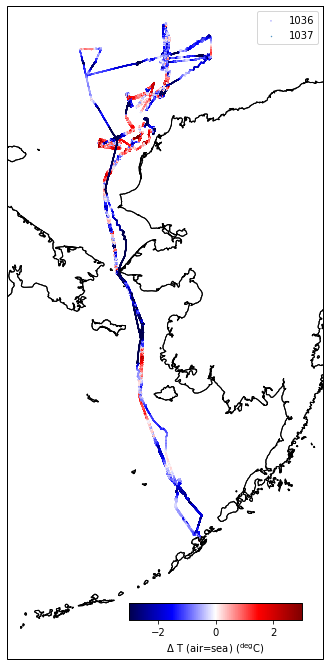

In [100]:
for i in range(2):
    fig = plt.figure(figsize=(8,12))
    ax = plt.axes(projection = ccrs.NorthPolarStereo(central_longitude=180.0))  # create a set of axes with Mercator projection
    ds2 = ds.isel(trajectory=i)
    rdif=ds2.TEMP_AIR_MEAN-ds2.TEMP_SBE37_MEAN
    im=ax.scatter(ds2.lon,ds2.lat,c=rdif,s=.15,vmin=-3,vmax=3,transform=ccrs.PlateCarree(),label=ds.trajectory[i].data,cmap='seismic')
    ax.coastlines(resolution='10m')                
    ax.set_extent([-180,-160,50,77])
    ax.legend()
    cax = fig.add_axes([0.45, 0.17, 0.3, 0.02])
    cbar = fig.colorbar(im,cax=cax, orientation='horizontal')
    cbar.set_label('$\Delta$ T (air=sea) ($^\deg$C)')
    fig.savefig(fig_dir+'figs/map_nasa'+str(i).zfill(2)+'_data_airseadif.png')    
fig = plt.figure(figsize=(8,12))
ax = plt.axes(projection = ccrs.NorthPolarStereo(central_longitude=180.0))  # create a set of axes with Mercator projection
for i in range(2):
    ds2 = ds.isel(trajectory=i)
    rdif=ds2.TEMP_AIR_MEAN-ds2.TEMP_SBE37_MEAN
    im=ax.scatter(ds2.lon,ds2.lat,c=rdif,s=.15,vmin=-3,vmax=3,transform=ccrs.PlateCarree(),label=ds.trajectory[i].data,cmap='seismic')
    ax.coastlines(resolution='10m')                
    ax.set_extent([-180,-160,50,77])
    ax.legend()
    cax = fig.add_axes([0.45, 0.17, 0.3, 0.02])
    cbar = fig.colorbar(im,cax=cax, orientation='horizontal')
    cbar.set_label('$\Delta$ T (air=sea) ($^\deg$C)')
    fig.savefig(fig_dir+'figs/map_nasa_data_airseadif.png')

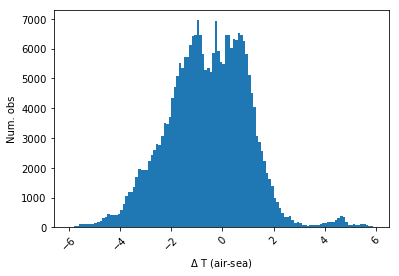

In [84]:
rdif=ds.TEMP_AIR_MEAN-ds.TEMP_SBE37_MEAN
sdif=rdif.stack(z=('trajectory','time'))
plt.hist(sdif,bins=np.arange(-6,6,.1))#,rwidth=0.25)
plt.xlabel('$\Delta$ T (air-sea)')
plt.ylabel('Num. obs')
plt.xticks(rotation=45)
fig.savefig(fig_dir+'nasa_air_hist.png', dpi=300)


## Look at any wind speed or time of day dependence on differences between two inflow 0.6m bulk SSTs

In [ ]:
#make diruanl plot
ds2=ds#.isel(trajectory=0)
xlon=ds2.lon
tdif=ds2.TEMP_CTD_RBR_MEAN-ds2.TEMP_SBE37_MEAN
time_offset_to_lmt=(xlon/360.)*24.*60
ds2['tlmt']=ds2.lon
for i in range(2):
    ds2['tlmt'][i,:]= ds2.time.data+time_offset_to_lmt[i,:]*np.timedelta64(1,'m')# dt.timedelta(seconds=1)

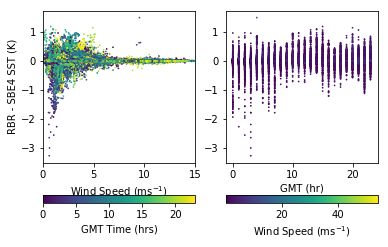

In [110]:
fig,(ax1,ax2) =plt.subplots(1,2)
for i in range(2):
    cs=ax1.scatter(ds2.wspd_MEAN[i,:],tdif[i,:],c=ds2.time.dt.hour,s=.5)
ax1.set(xlabel='Wind Speed (ms$^{-1}$)', ylabel='RBR - SBE4 SST (K)')
ax1.set_xlim(0,15)
cbar = fig.colorbar(cs,orientation='horizontal',ax=ax1)
cbar.set_label('GMT Time (hrs)')
for i in range(2):
    cs2=ax2.scatter(ds2.time.dt.hour,tdif[i,:],c=ds2.wspd_MEAN[i,:],s=.5)
ax2.set(xlabel='GMT (hr)')
cbar = fig.colorbar(cs2,orientation='horizontal',ax=ax2)
cbar.set_label('Wind Speed (ms$^{-1}$)')
fig.savefig(fig_dir+'figs/temp_buld_dw_data.png')

## Make differences

In [144]:
ds['tdif_temp']=ds.TEMP_CTD_RBR_MEAN-ds.TEMP_SBE37_MEAN
ds.tdif_temp.attrs=ds.TEMP_CTD_RBR_MEAN.attrs
ds.tdif_temp.attrs['long_name']='$\Delta$'+'(RBR - SBE) '+ds.tdif_temp.attrs['long_name']

ds['tdif_sal']=ds.SAL_RBR_MEAN-ds.SAL_SBE37_MEAN
ds.tdif_sal.attrs=ds.SAL_RBR_MEAN.attrs
ds.tdif_sal.attrs['long_name']='$\Delta$'+'(RBR - SBE) '+ds.tdif_sal.attrs['long_name']

ds['tdif_O2']=ds.O2_CONC_RBR_MEAN-ds.O2_CONC_SBE37_MEAN
ds.tdif_O2.attrs=ds.O2_CONC_RBR_MEAN.attrs
ds.tdif_O2.attrs['long_name']='$\Delta$'+'(RBR - SBE) '+ds.tdif_O2.attrs['long_name']

ds['tdif_Chlor']=ds.CHLOR_RBR_MEAN-ds.CHLOR_WETLABS_MEAN
ds.tdif_Chlor.attrs=ds.CHLOR_RBR_MEAN.attrs
ds.tdif_Chlor.attrs['long_name']='$\Delta$'+'(RBR - Wetlabs) '+ds.tdif_Chlor.attrs['long_name']


In [ ]:
print('CTD TEMP')
tdif=ds.tdif_temp
print(tdif.mean('time').data,tdif.std('time').data,sum(np.isfinite(tdif[0,:])).data,sum(np.isfinite(tdif[1,:])).data)
print('SAL')
tdif=ds.tdif_sal
print(tdif.mean('time').data,tdif.std('time').data,sum(np.isfinite(tdif[0,:])).data,sum(np.isfinite(tdif[1,:])).data)
print('O2 CONC')
tdif=ds.tdif_O2
print(tdif.mean('time').data,tdif.std('time').data,sum(np.isfinite(tdif[0,:])).data,sum(np.isfinite(tdif[1,:])).data)
print('Chlor')
tdif=ds.tdif_Chlor
print(tdif.mean('time').data,tdif.std('time').data,sum(np.isfinite(tdif[0,:])).data,sum(np.isfinite(tdif[1,:])).data)


CTD TEMP
[0.000285   0.00155487] [0.03737365 0.06910048] 180188 193657
SAL
[-0.16353538  0.84940364] [0.14910593 5.40145581] 180188 193657
O2 CONC


## Plot differences

In [143]:
for var in ds.variables:
    if 'tdif' in var:
        print(var)
        ax=ds[var][0,:].plot(linewidth=.5,color='r',label='1036')
        ax=ds[var][1,:].plot(linewidth=.5,color='b',label='1037')
        plt.legend()
        plt.title('')
        plt.savefig(fig_dir+'figs/'+var+'.png')
        plt.clf()

tdif_temp
tdif_sal
tdif_O2_conc
tdif_O2
tdif_Chlor


<Figure size 432x288 with 0 Axes>

## Code below here was for when we were using daily files

In [ ]:
#for dealing with daily files

adir = 'F:/data/cruise_data/saildrone/2019_arctic/daily_files/'
#list_usv=[1035,1036,1037]
list_usv=[1034,1035,1036,1037]
fig, axs = plt.subplots(len(list_usv),figsize=(10,10))
for iusv in list_usv:
    isub=iusv-np.min(list_usv)
    file = adir + 'arctic_2019_sd'+str(iusv)+'-NRT-1_min-v1.nc'
    ds = xr.open_dataset(file)
#get rid of data at the beginning of each file where instruments not in water
    if iusv==1033:
        ds = ds.sel(time=slice('2019-05-14T1800','2019-10-22'))
    if iusv==1034:
        ds = ds.sel(time=slice('2019-05-14T1830','2019-10-22'))
    if iusv==1035:
        ds = ds.sel(time=slice('2019-05-14T2230','2019-10-22'))
    if iusv==1036:
        ds = ds.sel(time=slice('2019-05-14T2300','2019-10-22'))
    if iusv==1037:
        ds = ds.sel(time=slice('2019-05-14T2250','2019-10-22'))
#get rid of bad salinity values
    ds = ds.where(ds.SAL_RBR_MEAN>20)
    ds = ds.where(ds.SAL_SBE37_MEAN>20)
#remove ice regions where salinity variability high
    ice = ds_ice.sel(usv=iusv)
    sdif=ds.SAL_SBE37_MEAN-ds.SAL_RBR_MEAN
    sdif2 = sdif.copy(deep=True)
    ind=sdif*0
    for i in range(ice.usv.size):
        cond = (sdif.time>ice.start_time[i]) & (sdif.time<ice.stop_time[i])
        sdif2[cond]=np.nan
    sdif.plot(ax=axs[isub])
    sdif2.plot(ax=axs[isub],color='r')   
    if iusv<1037:
        axs[isub].set_xticklabels('')
        axs[isub].set_xlabel(' ')
    strusv.append(str(iusv))
    print(iusv,sdif.mean().data,sdif.std().data)
#plt.legend(strusv)
fig.savefig(fig_dir+'figs/map_sal_ice_data.png')

In [ ]:
type(iusv)

In [ ]:
adir = 'F:/data/cruise_data/saildrone/2019_arctic/daily_files/'
#list_usv=[1035,1036,1037]
list_usv=[1034,1035,1036,1037]
strusv=[]
fig, axs = plt.subplots(len(list_usv),figsize=(10,10))
for iusv in list_usv:
    isub=iusv-np.min(list_usv)
    file = adir + 'arctic_2019_sd'+str(iusv)+'-NRT-1_min-v1.nc'
    ds = xr.open_dataset(file)
#get rid of data at the beginning of each file where instruments not in water
    if iusv==1033:
        ds = ds.sel(time=slice('2019-05-14T1800','2019-10-22'))
    if iusv==1034:
        ds = ds.sel(time=slice('2019-05-14T1830','2019-10-22'))
    if iusv==1035:
        ds = ds.sel(time=slice('2019-05-14T2230','2019-10-22'))
    if iusv==1036:
        ds = ds.sel(time=slice('2019-05-14T2300','2019-10-22'))
    if iusv==1037:
        ds = ds.sel(time=slice('2019-05-14T2250','2019-10-22'))
#get rid of bad salinity values
    ds = ds.where(ds.SAL_RBR_MEAN>20)
    ds = ds.where(ds.SAL_SBE37_MEAN>20)
#remove ice regions where salinity variability high
    ice = ds_ice.sel(usv=iusv)
    sdif=ds.SAL_SBE37_MEAN-ds.SAL_RBR_MEAN
    sdif2 = sdif.copy(deep=True)
    ind=sdif*0
    for i in range(ice.usv.size):
        cond = (sdif.time>ice.start_time[i]) & (sdif.time<ice.stop_time[i])
        sdif2[cond]=np.nan
    ax=axs[isub].scatter(ds.TEMP_CTD_RBR_MEAN,sdif)
    ax=axs[isub].scatter(ds.TEMP_CTD_RBR_MEAN,sdif2,color='r')   
    axs[isub].set_xlim([-2,12])
    axs[isub].set_ylim([-4,4])
    axs[isub].text(-1,3,str(iusv))
    if iusv<1037:
        axs[isub].set_xticklabels('')
        axs[isub].set_xlabel(' ')
    if iusv==1036:
        axs[isub].set_ylabel('Dif Sal SBE-RBR$')
    if iusv==1037:
        axs[isub].set_xlabel('SST')
    strusv.append(str(iusv))
    print(iusv,sdif.mean().data,sdif.std().data)
#plt.legend(strusv)
fig.savefig(fig_dir+'figs/map_sal_ice_data_temp.png')

#plt.plot(ds.TEMP_CTD_RBR_MEAN,sdif2,'.')

In [ ]:
adir = 'F:/data/cruise_data/saildrone/2019_arctic/daily_files/'
list_usv=[1035,1036,1037]
#list_usv=[1034,1035,1036,1037]
#fig, axs = plt.subplots(3,figsize=(10,10))
#for iusv in list_usv:
iusv=1036
file = adir + 'arctic_2019_sd'+str(iusv)+'-NRT-1_min-v1.nc'
ds = xr.open_dataset(file)
#get rid of data at the beginning of each file where instruments not in water
if iusv==1033:
    ds = ds.sel(time=slice('2019-05-14T1800','2019-10-22'))
if iusv==1034:
    ds = ds.sel(time=slice('2019-05-14T1830','2019-10-22'))
if iusv==1035:
    ds = ds.sel(time=slice('2019-05-14T2230','2019-10-22'))
if iusv==1036:
    ds = ds.sel(time=slice('2019-05-14T2300','2019-10-22'))
if iusv==1037:
    ds = ds.sel(time=slice('2019-05-14T2250','2019-10-22'))
ds['wspd']=np.sqrt(ds.UWND_MEAN**2+ds.VWND_MEAN**2)
#get rid of bad salinity values
ds = ds.where(ds.SAL_RBR_MEAN>20)
ds = ds.where(ds.wspd<30)
ds = ds.where(ds.SAL_SBE37_MEAN>20)
#remove ice regions where salinity variability high

fig, ax = plt.subplots(1,1)
ax.plot(ds.time,ds.TEMP_AIR_MEAN,'.',markersize=1,label='air')
ax.plot(ds.time,ds.TEMP_SBE37_MEAN,'.',markersize=1,label='bulk')
ax.set_xlabel('date')
ax.set_ylabel('air temperature (C)')
plt.xticks(rotation=45)
fig.savefig(fig_dir+'air_ts.png', dpi=300)
fig, ax = plt.subplots(1,1)
ax.plot(ds.time,ds.wspd,'.',markersize=1)
ax.set_xlabel('date')
ax.set_ylabel('wind speed (m/s)')
plt.xticks(rotation=45)
fig.savefig(fig_dir+'wnd_ts.png', dpi=300)
fig, ax = plt.subplots(1,1)
ax.plot(ds.time,ds.SAL_SBE37_MEAN,'.',markersize=1)
ax.set_xlabel('date')
ax.set_ylabel('Salinity (psu)')
plt.xticks(rotation=45)
fig.savefig(fig_dir+'sal_ts.png', dpi=300)


In [ ]:
fig, ax = plt.subplots(1,1)
ax.hist(ds.TEMP_AIR_MEAN-ds.TEMP_SBE37_MEAN,bins=np.arange(-5,5,.1))
ax.set_xlabel('$\Delta$ T (air-sea)')
ax.set_ylabel('Num. obs')
plt.xticks(rotation=45)
fig.savefig(fig_dir+'air_hist.png', dpi=300)


In [ ]:
#make diruanl plot
xlon=ds2.lon
tdif=ds2.TEMP_IR_SEA_WING_UNCOMP_MEAN-ds2.TEMP_SBE37_MEAN
time_offset_to_lmt=(xlon/360.)*24.*60
ds2['tlmt']=ds2.lon
for i in range(5):
    ds2['tlmt'][i,:]= ds2.time.data+time_offset_to_lmt[i,:]*np.timedelta64(1,'m')# dt.timedelta(seconds=1)
fig,(ax1,ax2) =plt.subplots(1,2)
for i in range(5):
    cs=ax1.scatter(ds2.wspd[i,:],tdif[i,:],c=ds2.time.dt.hour,s=.5)
ax1.set(xlabel='Wind Speed (ms$^{-1}$)', ylabel='SBE4 minus CTD SST (K)')
cbar = fig.colorbar(cs,orientation='horizontal',ax=ax1)
cbar.set_label('GMT Time (hrs)')
for i in range(5):
    cs2=ax2.scatter(ds2.time.dt.hour,tdif[i,:],c=ds2.wspd[i,:],s=.5)
ax2.set(xlabel='GMT (hr)')
cbar = fig.colorbar(cs2,orientation='horizontal',ax=ax2)
cbar.set_label('Wind Speed (ms$^{-1}$)')
fig.savefig(fig_dir+'diurnal/temp_data.png')

In [ ]:
subset

In [ ]:
ds2

In [ ]:
lon1,lon2

In [ ]:
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features
projection = ccrs.PlateCarree()
doy=ds2.time.dt.dayofyear
dmin=doy.min().data
dmax=doy.max().data
print(dmin,dmax)
i=0
for t in range(dmin,dmax,5):
    fig,axs =plt.subplots(3,3,figsize=(10,10))
    ax2 = plt.subplot(313, projection=ccrs.PlateCarree())
    cond=(t>=doy) & (t<(doy+5)) 
    if cond.sum()<100:
        continue
    for i in range(3):
        subset=ds2.isel(trajectory=i+1).where(cond,drop=True)
        if np.isfinite(subset.TEMP_CTD_RBR_MEAN).sum()<100:
            continue
        subset.TEMP_CTD_RBR_MEAN.plot(ax=axs[0,i],color='cyan')
        subset.TEMP_SBE37_MEAN.plot(ax=axs[0,i],color='blue')
        subset.TEMP_AIR_MEAN.plot(ax=axs[0,i],color='red')
        axs[0,i].set_xticklabels('')
        axs[0,i].set_xlabel(' ')
        subset.SAL_RBR_MEAN.plot(ax=axs[1,i],color='red',label='rbr')
        subset.SAL_SBE37_MEAN.plot(ax=axs[1,i],color='blue',label='sbe')
        ax=ax2
        im=ax.plot(subset.lon,subset.lat,label=ds2.trajectory[i].data)
        ax.coastlines(resolution='10m')  
        lon1,lon2=subset.lon.min().data-6,subset.lon.max().data+6
        lat1,lat2=subset.lat.min().data-6,subset.lat.max().data+6
        ax.set_extent([lon1,lon2,lat1,lat2])
        ax.legend(loc='lower left')
       
    fig.savefig(fig_dir+'daily_data'+str(t)+'.png')
    plt.close('all')

In [ ]:
#make some daily images
adir = 'F:/data/cruise_data/saildrone/2019_arctic/daily_files/'
list_usv=[1035,1036,1037]
#list_usv=[1034,1035,1036,1037]
fig, axs = plt.subplots(len(list_usv),figsize=(10,10))
for iusv in list_usv:
    isub=iusv-np.min(list_usv)
    subset=ds2.sel()
    axs[isub].ds2.
    file = adir + 'arctic_2019_sd'+str(iusv)+'-NRT-1_min-v1.nc'
    ds = xr.open_dataset(file)
#get rid of data at the beginning of each file where instruments not in water
    if iusv==1033:
        ds = ds.sel(time=slice('2019-05-14T1800','2019-10-22'))
    if iusv==1034:
        ds = ds.sel(time=slice('2019-05-14T1830','2019-10-22'))
    if iusv==1035:
        ds = ds.sel(time=slice('2019-05-14T2230','2019-10-22'))
    if iusv==1036:
        ds = ds.sel(time=slice('2019-05-14T2300','2019-10-22'))
    if iusv==1037:
        ds = ds.sel(time=slice('2019-05-14T2250','2019-10-22'))
#get rid of bad salinity values
    ds = ds.where(ds.SAL_RBR_MEAN>20)
    ds = ds.where(ds.SAL_SBE37_MEAN>20)
#remove ice regions where salinity variability high
    ice = ds_ice.sel(usv=iusv)
    sdif=ds.SAL_SBE37_MEAN-ds.SAL_RBR_MEAN
    sdif2 = sdif.copy(deep=True)
    ind=sdif*0
    for i in range(ice.usv.size):
        cond = (sdif.time>ice.start_time[i]) & (sdif.time<ice.stop_time[i])
        sdif2[cond]=np.nan
    sdif.plot(ax=axs[isub])
    sdif2.plot(ax=axs[isub],color='r')   
    if iusv<1037:
        axs[isub].set_xticklabels('')
        axs[isub].set_xlabel(' ')
    strusv.append(str(iusv))
    print(iusv,sdif.mean().data,sdif.std().data)
#plt.legend(strusv)
fig.savefig(fig_dir+'figs/map_sal_ice_data.png')

In [ ]:
#1034
iusv=1034
file = adir + 'arctic_2019_sd'+str(iusv)+'-NRT-1_min-v1.nc'
ds = xr.open_dataset(file)
fig,axs=plt.subplots(2)
sdif=ds.SAL_SBE37_MEAN-ds.SAL_RBR_MEAN
sdif.sel(time=slice('2019-06-10T0845','2019-07-30T16')).plot(ax=axs[0])
ds.SAL_SBE37_MEAN.sel(time=slice('2019-06-10T0845','2019-07-30T16')).plot(ax=axs[1],label='SBE')
ds.SAL_RBR_MEAN.sel(time=slice('2019-06-10T0845','2019-07-30T16')).plot(ax=axs[1],label='RBR')
axs[1].legend()
axs[1].set_ylim(20,35)
axs[0].set_ylim(-5,1)
axs[0].get_xaxis().set_ticks([])
#1035
#sdif.sel(time=slice('2019-06-14T0845','2019-06-14T16')).plot()
#sdif.sel(time=slice('2019-06-21T07','2019-06-21T13')).plot()
#sdif.sel(time=slice('2019-06-25T0445','2019-06-25T10')).plot()
#sdif.sel(time=slice('2019-06-26T20','2019-06-26T22')).plot()
#sdif.sel(time=slice('2019-08-6T18','2019-08-07T06')).plot()
#sdif.sel(time=slice('2019-08-9T02','2019-08-09T08')).plot()
#sdif.sel(time=slice('2019-08-10T05','2019-08-10T15')).plot()
#sdif.sel(time=slice('2019-08-11T07','2019-08-11T0930')).plot()
#sdif.sel(time=slice('2019-08-20T1030','2019-08-20T14')).plot()
#sdif.sel(time=slice('2019-08-22T2230','2019-08-24T05')).plot()
#1036
#sdif.sel(time=slice('2019-06-17T06','2019-06-17T21')).plot()
#sdif.sel(time=slice('2019-06-22T17','2019-06-22T22')).plot()
#sdif.sel(time=slice('2019-06-23T00','2019-06-23T08')).plot()
#sdif.sel(time=slice('2019-07-18T00','2019-07-18T01')).plot()
#sdif.sel(time=slice('2019-08-06T20','2019-08-07T02')).plot()
#sdif.sel(time=slice('2019-08-08T06','2019-08-10T04')).plot()
#sdif.sel(time=slice('2019-07-07','2019-07-11T12')).plot() #super calm period RBR appears to be bad



In [ ]:
ds

In [ ]:
adir = 'F:/data/cruise_data/saildrone/2019_arctic/daily_files/'
strusv=[]
for iusv in range(1033,1038):
    file = adir + 'arctic_2019_sd'+str(iusv)+'-NRT-1_min-v1.nc'
    ds = xr.open_dataset(file)
    ds['spd']=np.sqrt(ds.UWND_MEAN**2+ds.VWND_MEAN**2)
    #ds = ds.where(ds.SA_CTD_RBR_MEAN>20)
    #ds = ds.where(ds.TEMP_SBE37_MEAN>20)
    ds2 = ds.isel(time=slice(250,-1))
    sdif=ds2.TEMP_SBE37_MEAN-ds2.TEMP_CTD_RBR_MEAN
    ax=sdif.plot()
    strusv.append(str(iusv))
    print(iusv,sdif.mean().data,sdif.std().data)
plt.legend(strusv)
plt.ylabel('$\Delta$ SST (K)')
fig.savefig(fig_dir+'figs/all_sal_ice_data.png')

In [ ]:
iusv=1033
file = adir + 'arctic_2019_sd'+str(iusv)+'-NRT-1_min-v1.nc'
ds = xr.open_dataset(file)
ds['spd']=np.sqrt(ds.UWND_MEAN**2+ds.VWND_MEAN**2)
#ds = ds.where(ds.SA_CTD_RBR_MEAN>20)
#ds = ds.where(ds.TEMP_SBE37_MEAN>20)
ds2 = ds.isel(time=slice(250,-1))
sdif=ds2.TEMP_SBE37_MEAN-ds2.TEMP_CTD_RBR_MEAN


In [ ]:
ds2 = ds.sel(time=slice('2019-08-05','2019-08-30'))
sdif=ds2.TEMP_SBE37_MEAN-ds2.TEMP_CTD_RBR_MEAN
sdif.plot()

In [ ]:
#Δρ=α*ΔT+βΔS
#α=0.2 #kg m-3 c-1
#β=1 #km m-3 psu-1
s, t, p = 40, 10, 4000
sw.alpha(s,t,p,pt=True)  #salinity psu, temperature deg C, pressure db, pt true if potential
sw.beta(s,t,p,pt=True)  #salinity psu, temperature deg C, pressure db, pt true if potential
sw.aonb(s,t,p,pt=True)
sw.dens0(s,t)

In [ ]:
iusv=1033
file = adir + 'arctic_2019_sd'+str(iusv)+'-NRT-1_min-v1.nc'
ds = xr.open_dataset(file)
ds.close()
tem=sw.dens0(ds.SAL_SBE37_MEAN,ds.TEMP_SBE37_MEAN)
ds['density']=xr.DataArray(tem,dims='time',coords={'time':ds.time})
tem=sw.alpha(ds.SAL_SBE37_MEAN,ds.TEMP_SBE37_MEAN,ds.BARO_PRES_MEAN*0) #pressure =0 at surface
ds['alpha']=xr.DataArray(tem,dims='time',coords={'time':ds.time})
tem=sw.beta(ds.SAL_SBE37_MEAN,ds.TEMP_SBE37_MEAN,ds.BARO_PRES_MEAN*0) #pressure =0 at surface
ds['beta']=xr.DataArray(tem,dims='time',coords={'time':ds.time})
from geopy.distance import vincenty
temdata=[]
for i in range(ds.lat.size-1):
    if np.all(np.isfinite([ds.lat[i:i+2].data,ds.lon[i:i+2].data])):
        coords_1 = (ds.lat[i], ds.lon[i])  #cpr sample location
        coords_2 = (ds.lat[i+1], ds.lon[i+1])  #eddy location
        tem = geopy.distance.distance(coords_1, coords_2).km
        temdata.append(tem)
    else:
        temdata.append(np.nan)
temdata.append(tem)
ds['dist_km']=xr.DataArray(temdata,dims='time',coords={'time':ds.time})


In [ ]:
plt.hist(ds.dist_km*1000,np.arange(0,150,1))

In [ ]:
iusv=1033
file = adir + 'arctic_2019_sd'+str(iusv)+'-NRT-1_min-v1.nc'
ds = xr.open_dataset(file)
ds.close()
ds

In [ ]:
ds.SAL_RBR_MEAN[-20000:].plot()

In [ ]:
ds.SOG[1000:1100].plot()
#print(ds.time[1350].data)

In [ ]:
import geopy
arclen_temp

In [ ]:
plt.scatter(ds.spd,ds.WAVE_SIGNIFICANT_HEIGHT)

In [ ]:
plt.scatter(ds.spd,ds.WAVE_DOMINANT_PERIOD)

In [ ]:
subset=ds.where(ds.WAVE_DOMINANT_PERIOD>20,drop=True)
subset.WAVE_DOMINANT_PERIOD.plot(marker='.')

In [ ]:
print(subset.time.data)

In [ ]:
(ds.TEMP_IR_SEA_WING_UNCOMP_MEAN-ds.TEMP_SBE37_MEAN).sel(time=slice('2019-07-10','2019-07-21')).plot()

In [ ]:
(.96*ds.TEMP_IR_SEA_HULL_UNCOMP_MEAN+0.04*ds.TEMP_IR_SKY_HULL_MEAN).plot()
ds.TEMP_SBE37_MEAN.plot(color='r')

In [ ]:
ds=ds.isel(time=slice(200,-1))

In [ ]:
#ds.TEMP_IR_SEA_HULL_UNCOMP_MEAN.plot(color='k')
ds2 = ds.sel(time=slice('2019-05-15','2019-06-16'))
skin=.99*ds2.TEMP_IR_SEA_WING_UNCOMP_MEAN-.01*ds2.TEMP_IR_SKY_HULL_MEAN
#(.98*ds2.TEMP_IR_SEA_WING_UNCOMP_MEAN-.02*ds2.TEMP_IR_SKY_HULL_MEAN).plot(color='b')
skin.plot(color='b')
ds2.TEMP_SBE37_MEAN.plot(color='r')
#0.04*(ds2.TEMP_IR_SKY_HULL_MEAN).plot()

In [ ]:
skin=.99*ds2.TEMP_IR_SEA_WING_UNCOMP_MEAN-.01*ds2.TEMP_IR_SKY_HULL_MEAN
print((skin-ds2.TEMP_SBE37_MEAN).std().data)
skin=ds2.TEMP_IR_SEA_WING_UNCOMP_MEAN
print((skin-ds2.TEMP_SBE37_MEAN).std().data)

In [ ]:
subset=ds.sel(time=slice('2019-06-16','2019-06-25'))
subset.SOG.plot(marker='.')

In [ ]:
subset = ds.where(np.isfinite(ds.WAVE_SIGNIFICANT_HEIGHT),drop=True)
subset.WAVE_SIGNIFICANT_HEIGHT.plot()

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
#cond = np.isfinite(ds.TEMP_IR_SEA_HULL_UNCOMP_MEAN) # & np.isfinite(ds.TEMP_IR_SKY_HULL_MEAN) & np.isfinite(ds.TEMP_SBE37_MEAN)
#ds2=ds[cond]
ds2 = ds.where(np.isfinite(ds.TEMP_IR_SEA_HULL_UNCOMP_MEAN))
ds2 = ds2.where(np.isfinite(ds.TEMP_IR_SKY_HULL_MEAN))
ds2 = ds2.where(np.isfinite(ds.TEMP_SBE37_MEAN))


In [ ]:
X = [ds2.TEMP_IR_SEA_HULL_UNCOMP_MEAN, ds2.TEMP_IR_SKY_HULL_MEAN]
# y = 1 * x_0 + 2 * x_1 + 3
y = ds2.TEMP_SBE37_MEAN
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_) 

In [ ]:
#OLD
adir = 'F:/data/cruise_data/saildrone/2019_arctic/post_mission/'
list_usv=[1033,1034,1035,1036,1037]
for iusv in list_usv:
    file = adir + 'saildrone-gen_5-arctic_misst_2019-sd'+str(iusv)+'-20190514T230000-20191011T183000-1_minutes-v1.1575487464625.nc'
    ds = xr.open_dataset(file)
    if iusv==1033:
        ds = ds.sel(time=slice('2019-05-14T1800','2019-10-22'))
        ds2=ds
    if iusv==1034:
        ds = ds.sel(time=slice('2019-05-14T1830','2019-10-22'))
        ds['WIND_MEASUREMENT_HEIGHT_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['WIND_MEASUREMENT_HEIGHT_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds2=xr.concat([ds2,ds],dim='trajectory')
    if iusv==1035:
        ds = ds.sel(time=slice('2019-05-14T2230','2019-10-22'))
        ds['WIND_HEIGHT_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['WIND_HEIGHT_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds2=xr.concat([ds2,ds],dim='trajectory')
    if iusv==1036:
        ds = ds.sel(time=slice('2019-05-14T2300','2019-10-22'))
        ds['LW_IRRAD_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['LW_IRRAD_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['SW_IRRAD_TOTAL_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['SW_IRRAD_TOTAL_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['SW_IRRAD_DIFFUSE_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['SW_IRRAD_DIFFUSE_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['O2_CONC_AANDERAA_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['O2_CONC_AANDERAA_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['O2_SAT_AANDERAA_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['O2_SAT_AANDERAA_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['TEMP_O2_AANDERAA_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['TEMP_O2_AANDERAA_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['O2_TC_PHASE_AANDERAA_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['O2_TC_PHASE_AANDERAA_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['SW_UNMASKED_IRRAD_6DET_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['SW_UNMASKED_IRRAD_6DET_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['SW_UNMASKED_IRRAD_CENTER_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['SW_UNMASKED_IRRAD_CENTER_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['LW_IRRAD_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['LW_IRRAD_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['WIND_MEASUREMENT_HEIGHT_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['WIND_MEASUREMENT_HEIGHT_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds2=xr.concat([ds2,ds],dim='trajectory')
    if iusv==1037:
        ds = ds.sel(time=slice('2019-05-14T2250','2019-10-22'))
        ds['LW_IRRAD_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['LW_IRRAD_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['SW_IRRAD_TOTAL_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['SW_IRRAD_TOTAL_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['SW_IRRAD_DIFFUSE_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['SW_IRRAD_DIFFUSE_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['O2_CONC_AANDERAA_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['O2_CONC_AANDERAA_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['O2_SAT_AANDERAA_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['O2_SAT_AANDERAA_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['TEMP_O2_AANDERAA_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['TEMP_O2_AANDERAA_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['O2_TC_PHASE_AANDERAA_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['O2_TC_PHASE_AANDERAA_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['SW_UNMASKED_IRRAD_6DET_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['SW_UNMASKED_IRRAD_6DET_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['SW_UNMASKED_IRRAD_CENTER_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['SW_UNMASKED_IRRAD_CENTER_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['LW_IRRAD_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['LW_IRRAD_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds['WIND_MEASUREMENT_HEIGHT_MEAN']=ds['TEMP_AIR_MEAN']*np.nan
        ds['WIND_MEASUREMENT_HEIGHT_STDDEV']=ds['TEMP_AIR_MEAN']*np.nan
        ds2=xr.concat([ds2,ds],dim='trajectory')
ds2['wspd']=np.sqrt(ds2.UWND_MEAN**2+ds2.VWND_MEAN**2)
ds2['wdir']=np.arctan2(ds2.VWND_MEAN,ds2.UWND_MEAN)*180./np.pi

In [ ]:
#not working
from scipy.stats import kde
rdif=ds.TEMP_AIR_MEAN-ds.TEMP_SBE37_MEAN
x=rdif.stack(z=('trajectory','time'))
y=ds.wdir.stack(z=('trajectory','time'))
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.show()
 
#plt.bar(edges,H,bins=np.arange(-6,6,.1))#,rwidth=0.25)
#plt.xlabel('$\Delta$ T (air-sea)')
#plt.ylabel('Num. obs')
#plt.xticks(rotation=45)
#fig.savefig(fig_dir+'air_wdir_hist.png', dpi=300)
